In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs

In [ ]:
data = pd.read_pickle("/home/abhirup/sanchari/gpr4im/Data/example_data.pkl")
FGnopol_HI_noise_data = data.beam.FGnopol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs


In [ ]:
np.shape(data.beam.noise)

(128, 128, 142)

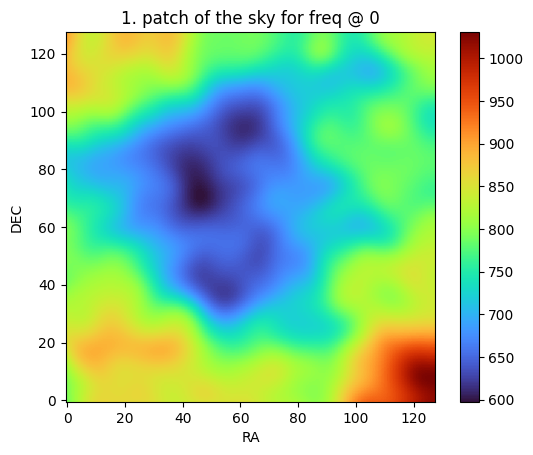

In [ ]:
plt.imshow(FGnopol_HI_noise_data[:,:,0],cmap="turbo",origin="lower")  #patch of the sky for freq@0
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("1. patch of the sky for freq @ 0")
# plt.imshow(FGnopol_HI_noise_data[:,:,100],cmap="turbo",origin="lower")
plt.colorbar()

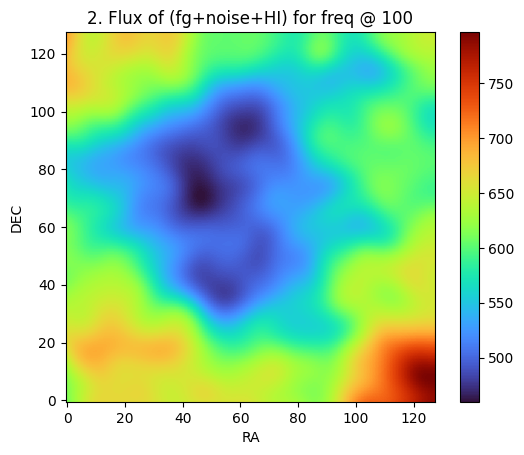

In [ ]:
plt.imshow(FGnopol_HI_noise_data[:,:,100],cmap="turbo",origin="lower") #patch of the sky for freq @ 1oo
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("2. Flux of (fg+noise+HI) for freq @ 100")
plt.colorbar()

Text(0.5, 1.0, '3. Freq variation for a particular sky patch (raw data)')

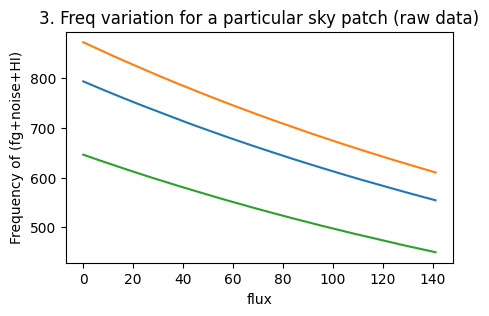

In [ ]:
# plt.xscale("log")
# plt.yscale("log")
plt.figure(figsize=(5,3))
plt.plot(FGnopol_HI_noise_data[0,0,:])  #freq variation for a particular sky patch
plt.plot(FGnopol_HI_noise_data[10,10,:])
plt.plot(FGnopol_HI_noise_data[50,50,:])
plt.xlabel("flux")
plt.ylabel("Frequency of (fg+noise+HI)")
plt.title("3. Freq variation for a particular sky patch (raw data)")

Text(0.5, 1.0, '4. Flux of (noise+HI) for freq @ 20 (the reference data)')

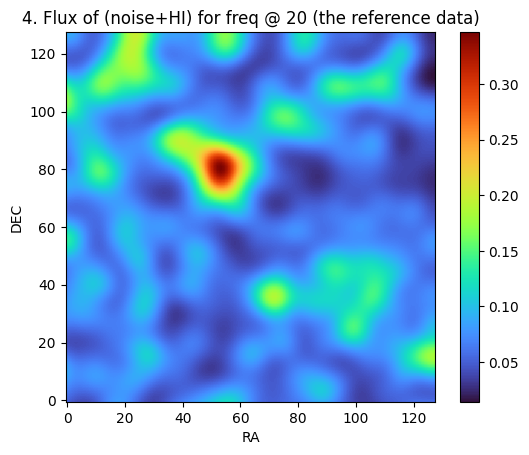

In [ ]:
plt.imshow(HI_noise_data[:,:,20],cmap="turbo",origin="lower")
plt.colorbar()
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("4. Flux of (noise+HI) for freq @ 20 (the reference data)")

Text(0.5, 1.0, '5. Flux of (noise+HI) for freq @ 0 (the reference data)')

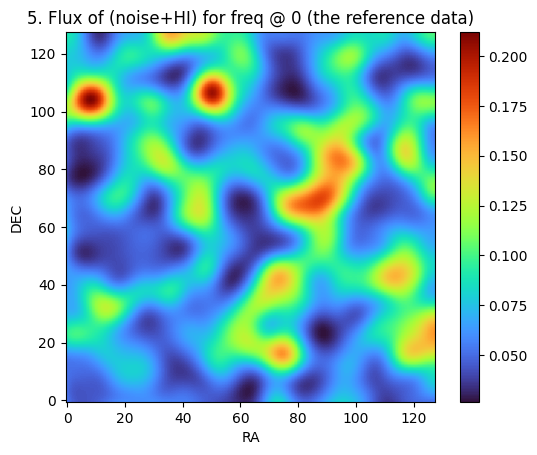

In [ ]:
plt.imshow(HI_noise_data[:,:,0],cmap="turbo",origin="lower")
plt.colorbar()
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("5. Flux of (noise+HI) for freq @ 0 (the reference data)")

Text(0.5, 1.0, '6. Freq variation for a particular sky patch (given data without fg)')

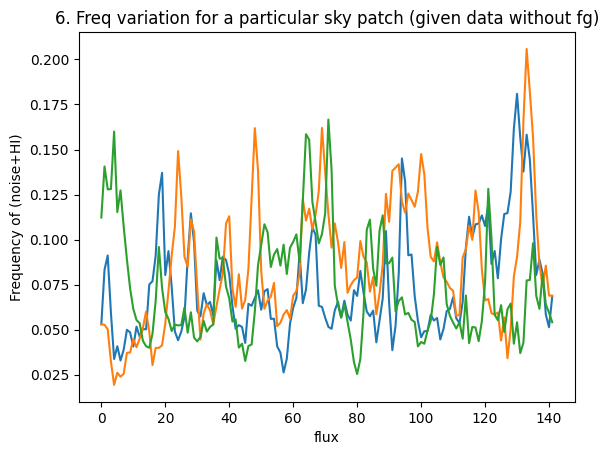

In [ ]:
# plt.xscale("log")
# plt.yscale("log")
plt.plot(HI_noise_data[10,10,:])
plt.plot(HI_noise_data[0,0,:])
plt.plot(HI_noise_data[100,100,:])
plt.xlabel("flux")
plt.ylabel("Frequency of (noise+HI)")
plt.title("6. Freq variation for a particular sky patch (given data without fg)")

# plt.plot(FGnopol_HI_noise_data[10,10,:])

In [ ]:
# kernel for the smooth foreground:
kern_fg = GPy.kern.RBF(1)
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

In [ ]:
kern_fg.variance.constrain_bounded(1000,100000000)
kern_fg.lengthscale.constrain_bounded(200,10000)
# setting priors for the HI kernel:
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


In [ ]:
kern = kern_fg + kern_21

In [ ]:
Input = FGnopol_HI_noise_data
num_restarts = 10
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

In [ ]:
axes = np.shape(Input)

# if desired, do a pre-PCA with N_FG=NprePCA removed components
if NprePCA > 0: Input = fg.PCAclean(Input, N_FG=NprePCA)[0]

# converting data format to LoS pixels [Nx,Ny,Nz] -> [Npix,Nz]
Input = obs.LoSpixels(Input)
if noise_data is not None: noise_data = obs.LoSpixels(noise_data)

# invert frequency axis
if invert==True:
    Input = Input[::-1]
    if noise_data is not None: noise_data = noise_data[::-1]

In [ ]:
if heteroscedastic==True:
    # this case assumes noise is known, sets noise level to your noise_data variances
        # at different frequencies (since heteroscedastic)
    if noise_data is not None:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
        model.het_Gauss.variance.constrain_fixed(noise_data.var(axis=1)[:, None])
    # this case assumes noise is not known, model will fit a variance at each frequency
    else:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
    # note: if you want the case of *no noise*, there's no need to use heteroscedastic,
        # so set heteroscedastic = False and see below

# this non-heteroscedastic case assumes constant Gaussian noise variance through frequency
else:
    # this case assumes noise is known, sets the noise variance level to the variance
        # from the input noise_data
    if noise_data is not None:
        model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
        model.Gaussian_noise.constrain_fixed(noise_data.var())
    else:
        # this case assumes there is no noise in your data
        if zero_noise == True:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
            model['.*Gaussian_noise'] = 0.0
            model['.*noise'].fix()
        # this case assumes there is noise but it is unknown, fits a constant variance
        else:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)


In [ ]:
model.optimize_restarts(num_restarts = num_restarts)

 /home/abhirup/.local/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -5728921.915524915
Optimization restart 2/10, f = -5744408.88905147
Optimization restart 3/10, f = -5744408.87514509
Optimization restart 4/10, f = -5744408.87976131
Optimization restart 5/10, f = -5728931.952928456
Optimization restart 6/10, f = -5728921.8015607735
Optimization restart 7/10, f = -5744408.884699388
Optimization restart 8/10, f = -5728934.015109281
Optimization restart 9/10, f = -5744408.880088249
Optimization restart 10/10, f = -5728952.5779372705


In [ ]:
print(model.objective_function())

-5744408.88905147


In [ ]:
print(model.log_likelihood())

5744408.88905147


In [ ]:
print(model)


Name : GP regression
Objective : -5744408.88905147
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.               |                  value  |     constraints      |  priors
  sum.rbf.variance             |     16779.953873234692  |  1000.0,100000000.0  |        
  sum.rbf.lengthscale          |     457.48653831933916  |    200.0,10000.0     |        
  sum.Exponential.variance     |  0.0010005778289176128  |      1e-06,0.5       |        
  sum.Exponential.lengthscale  |      5.575337321336071  |      0.01,15.0       |        
  Gaussian_noise.variance      |                    0.0  |      +ve fixed       |        


In [ ]:
if kern_fg.name == 'sum': # if there is more than one foreground kernel
    k_fg_length = len(kern_fg.parts)          ## bujhte parchi na ki hochhe ekhane!!
    k_fg = model.kern.parts[0]
    if k_fg_length > 1:
        for i in range(1, k_fg_length):
            k_fg += model.kern.parts[i]
else: k_fg = model.kern.parts[0] # if there is only one foreground kernel

# make prediction of what the FGs would look like using this optimised FG kernel:
fg_fit, fg_cov = model.predict(freqs[:, np.newaxis], full_cov=True, kern=k_fg,
    include_likelihood=False)

# subtract the expected FG from data, to obtain the HI+noise residual:
gpr_res = Input - fg_fit

# un-invert data:
if invert==True:
    gpr_res = gpr_res[::-1]
    fg_fit = fg_fit[::-1]

# reshape residuals back to [Nx, Ny, Nz]
gpr_res = np.swapaxes(gpr_res,0,1)
gpr_res = np.reshape(gpr_res,(axes[0], axes[1], axes[2]))

# also reshape foreground fit back to [Nx, Ny, Nz]
fg_fit = np.swapaxes(fg_fit,0,1)
fg_fit = np.reshape(fg_fit,(axes[0], axes[1], axes[2]))

# create Series as the output object, containing all the important results
d = {'res': gpr_res, 'fgcov': fg_cov, 'fgfit': fg_fit, 'model': model}
gpr_result = pd.Series(d)

In [ ]:
print(gpr_result.model)


Name : GP regression
Objective : -5744408.88905147
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.               |                  value  |     constraints      |  priors
  sum.rbf.variance             |     16779.953873234692  |  1000.0,100000000.0  |        
  sum.rbf.lengthscale          |     457.48653831933916  |    200.0,10000.0     |        
  sum.Exponential.variance     |  0.0010005778289176128  |      1e-06,0.5       |        
  sum.Exponential.lengthscale  |      5.575337321336071  |      0.01,15.0       |        
  Gaussian_noise.variance      |                    0.0  |      +ve fixed       |        


In [ ]:
np.shape(gpr_result.res)

(128, 128, 142)

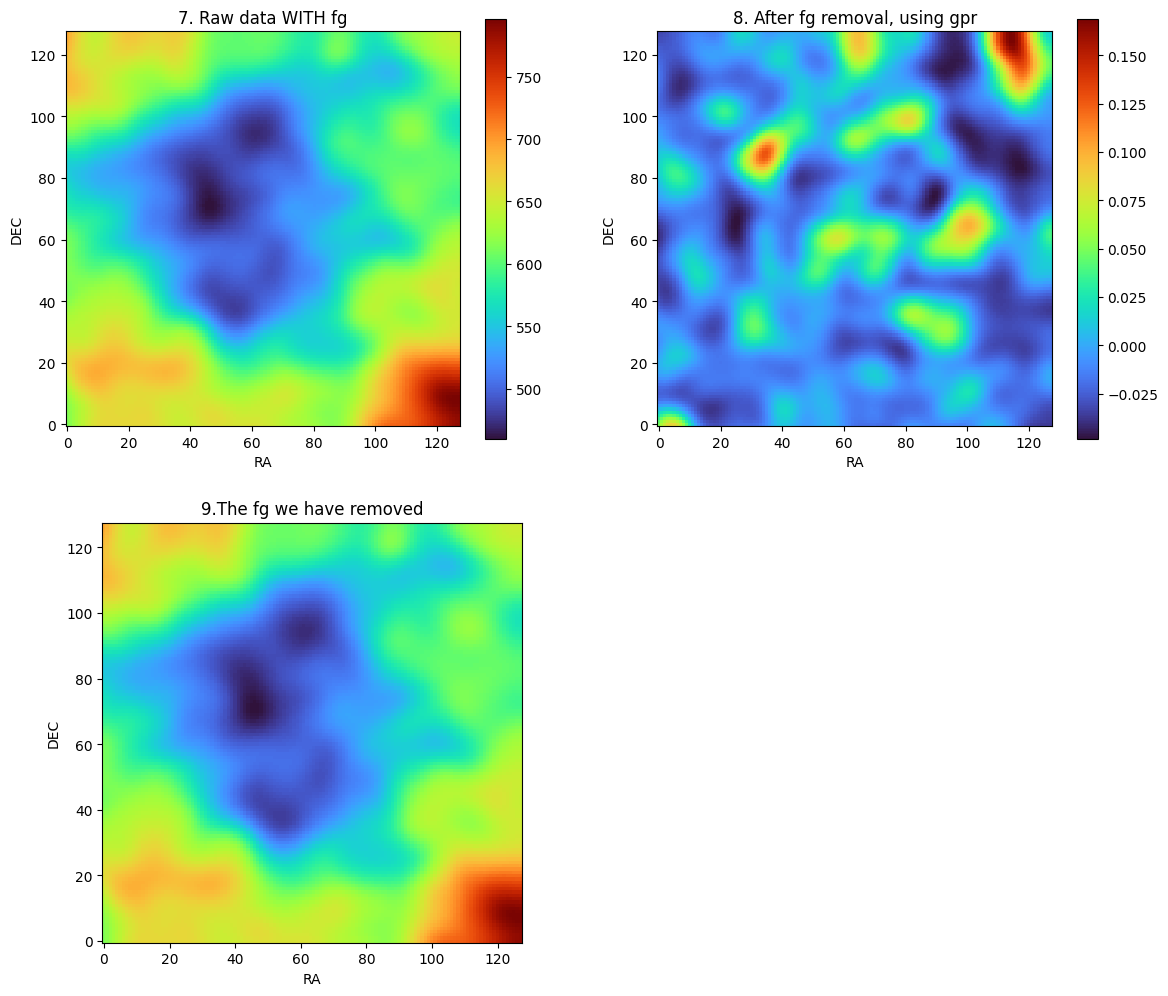

In [ ]:
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(FGnopol_HI_noise_data[:,:,100],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("7. Raw data WITH fg")
plt.colorbar()
plt.subplot(223)
plt.imshow(gpr_result.fgfit[:,:,10],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("9.The fg we have removed")
plt.colorbar
plt.subplot(222)
plt.imshow(gpr_result.res[:,:,100],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("8. After fg removal, using gpr")
plt.colorbar()

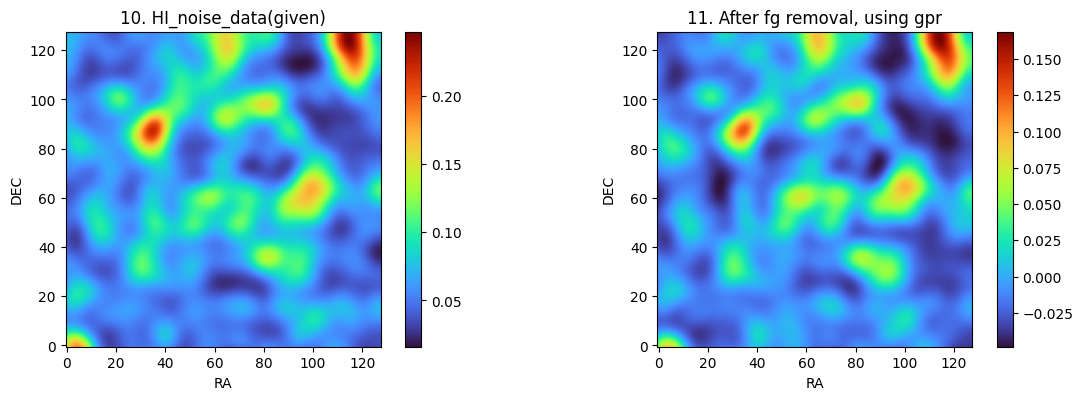

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(221)
plt.imshow(HI_noise_data[:,:,100],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("10. HI_noise_data(given)")
plt.colorbar()
# plt.subplot(223)
# plt.imshow(gpr_result.fgfit[:,:,10],cmap="bwr")
plt.subplot(222)
plt.imshow(gpr_result.res[:,:,100],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("11. After fg removal, using gpr")
plt.colorbar()

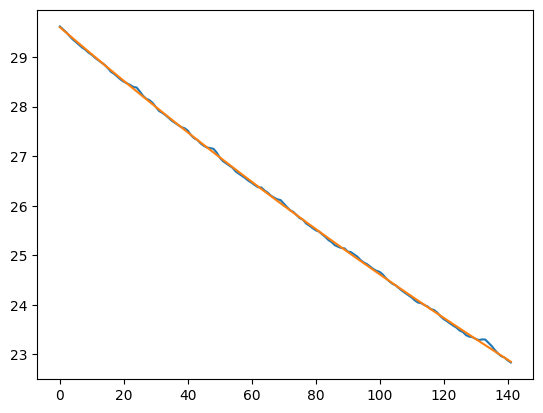

In [ ]:
plt.plot(FGnopol_HI_noise_data[0,0,:])
plt.plot(gpr_result.fgfit[0,0,:])


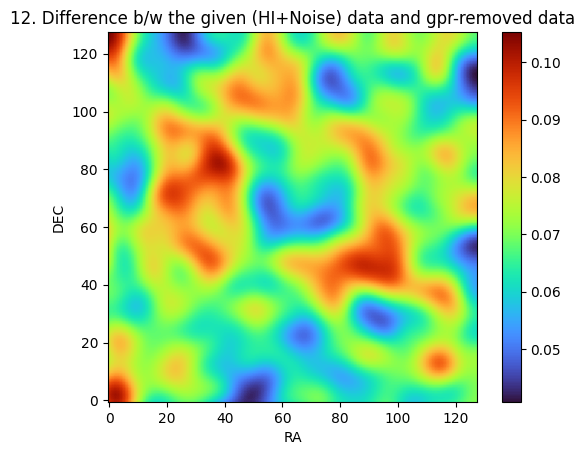

In [ ]:
removal=HI_noise_data-gpr_result.res
plt.imshow(removal[:,:,100],cmap="turbo",origin="lower")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("12. Difference b/w the given (HI+Noise) data and gpr-removed data")
plt.colorbar()


Text(0.5, 1.0, '13. Freq variation for a particular sky patch (after fg removal by gpr)')

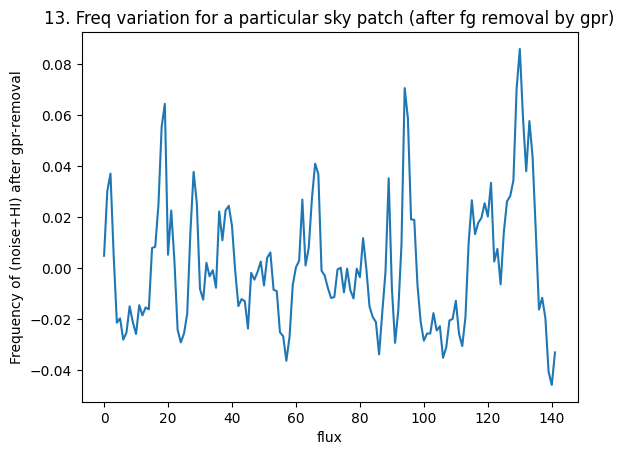

In [ ]:
plt.plot(gpr_result.res[10,10,:])
plt.xlabel("flux")
plt.ylabel("Frequency of (noise+HI) after gpr-removal")
plt.title("13. Freq variation for a particular sky patch (after fg removal by gpr)")


Text(0.5, 1.0, '14. noise variation')

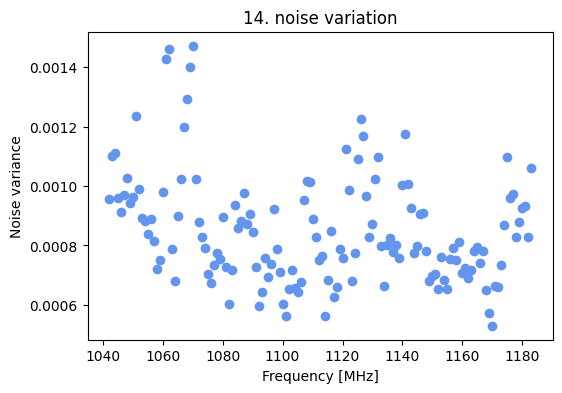

In [ ]:
noise_var = obs.LoSpixels(HI_noise_data).var(axis=1)
plt.figure(figsize=(6,4))
plt.scatter(freqs, noise_var, c='cornflowerblue')
plt.ylabel('Noise variance')
plt.xlabel('Frequency [MHz]')
plt.title("14. noise variation")

In [ ]:
noise_data = data.beam.noise
# noise_var = (noise_data).var(axis=1)

In [ ]:
np.shape(noise_data)

(128, 128, 142)

Text(0.5, 1.0, '15. noise given in dataset(sample)')

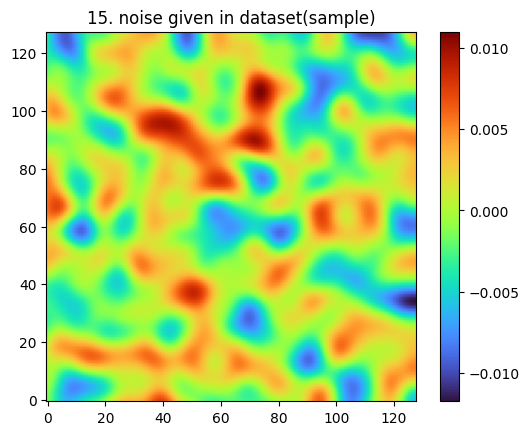

In [ ]:
plt.imshow(noise_data[:,:,100],cmap="turbo",origin="lower")
plt.colorbar()
plt.title("15. noise given in dataset(sample)")

In [ ]:
print(noise_var)

[0.00095488 0.00110141 0.00111164 0.00095863 0.0009116  0.00096986
 0.00102593 0.00094261 0.00096257 0.00123671 0.00098953 0.00089136
 0.00088229 0.00083809 0.00088968 0.00081345 0.00072231 0.00075027
 0.00097858 0.00142905 0.00146273 0.00078801 0.00067878 0.00089989
 0.00102426 0.001198   0.00129377 0.00139947 0.00147281 0.00102294
 0.00088028 0.00082874 0.00079155 0.00070316 0.00067304 0.00073499
 0.00077371 0.00075514 0.00089638 0.00072678 0.00060238 0.00071632
 0.00093758 0.00085916 0.00088168 0.00097509 0.00087166 0.00090768
 0.00084578 0.00072911 0.00059497 0.00064185 0.00075861 0.0006929
 0.00073665 0.00092447 0.000788   0.00070901 0.00060336 0.00056141
 0.00065496 0.00071705 0.00065591 0.00064388 0.00067643 0.00095454
 0.00101661 0.0010129  0.00088962 0.00082966 0.00075016 0.00076419
 0.0005637  0.00068378 0.00084952 0.00062725 0.00066099 0.00078731
 0.00075689 0.00112356 0.00098604 0.00068159 0.0007743  0.00109274
 0.00122494 0.00116903 0.00096533 0.00082913 0.00087309 0.00102

In [ ]:
pure_hi_sample=HI_noise_data-noise_data
pure_hi_my_sample=gpr_result.res-noise_data

Text(0.5, 1.0, '17. pure hi, from foreground removed data and given noise')

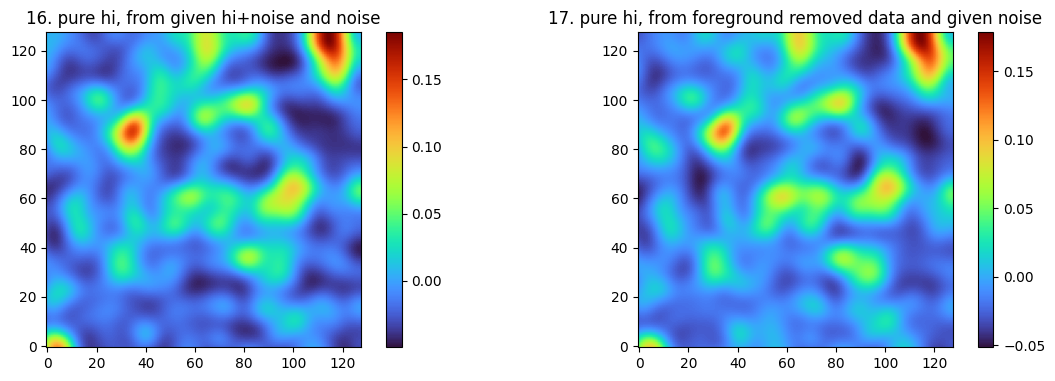

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(221)
plt.imshow(pure_hi_sample[:,:,100],cmap="turbo",origin="lower")
plt.colorbar()
plt.title("16. pure hi, from given hi+noise and noise")
plt.subplot(222)
plt.imshow(pure_hi_my_sample[:,:,100],cmap="turbo",origin="lower")
plt.colorbar()
plt.title("17. pure hi, from foreground removed data and given noise")

In [ ]:
i=np.identity(128)
var_n=i*noise_data.var()
var_n_hi_sample=i*HI_noise_data.var()
var_n_hi=i*gpr_result.res.var()

In [ ]:
m=gpr_result.res[:,:,100]-var_n
n=gpr_result.res[:,:,100]-var_n_hi_sample
o=gpr_result.res[:,:,100]-var_n_hi

Text(0.5, 1.0, '20 hi, from sigma-hi+noise(given)')

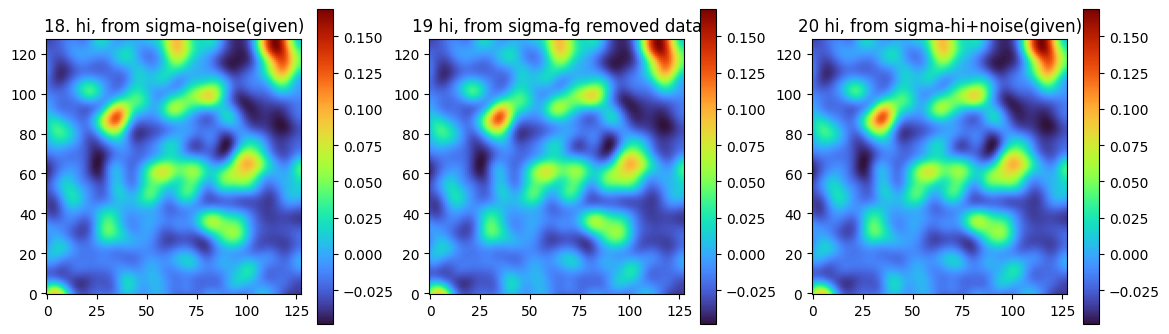

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(231)
plt.imshow(m,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("18. hi, from sigma-noise(given)")
plt.subplot(232)
plt.imshow(n,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("19 hi, from sigma-fg removed data")
plt.subplot(233)
plt.imshow(o,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("20 hi, from sigma-hi+noise(given)")

In [ ]:
m2=HI_noise_data[:,:,100]-var_n
n2=HI_noise_data[:,:,100]-var_n_hi_sample
o2=HI_noise_data[:,:,100]-var_n_hi

Text(0.5, 1.0, '23')

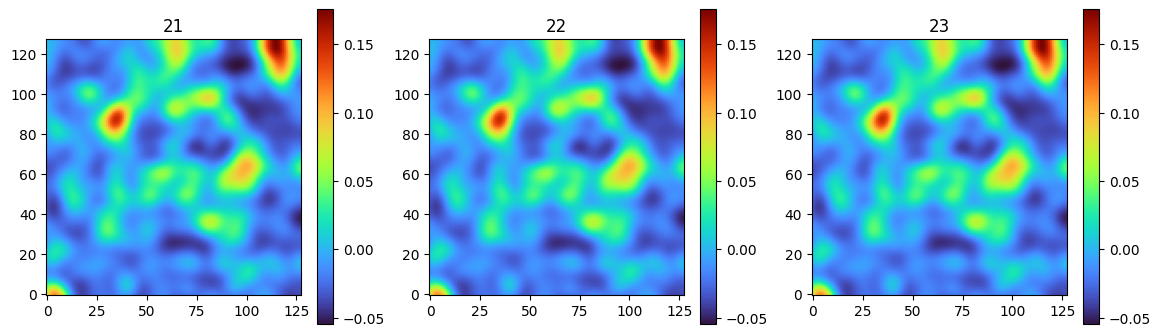

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(231)
plt.imshow(m2,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("21")
plt.subplot(232)
plt.imshow(n2,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("22")
plt.subplot(233)
plt.imshow(o2,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("23")

Text(0.5, 1.0, '24')

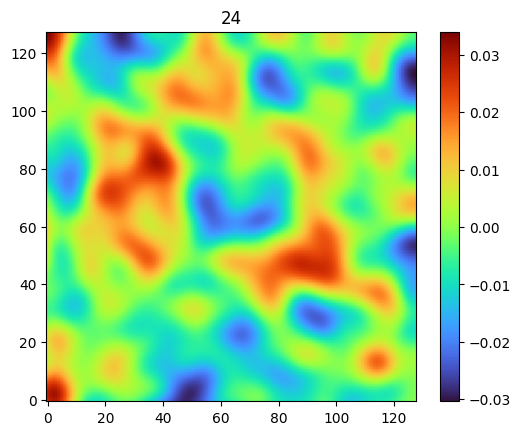

In [ ]:
# to compare HI signal difference between 16 and 17
diff1=pure_hi_sample-pure_hi_my_sample
plt.imshow(diff1[:,:,100],cmap="turbo",origin="lower")
plt.colorbar()
plt.title("24")

In [ ]:
diff2=pure_hi_sample[:,:,100]-m
diff3=pure_hi_sample[:,:,100]-n
diff4=pure_hi_sample[:,:,100]-o
diff5=pure_hi_sample[:,:,100]-m2
diff6=pure_hi_sample[:,:,100]-n2
diff7=pure_hi_sample[:,:,100]-o2

Text(0.5, 1.0, '30')

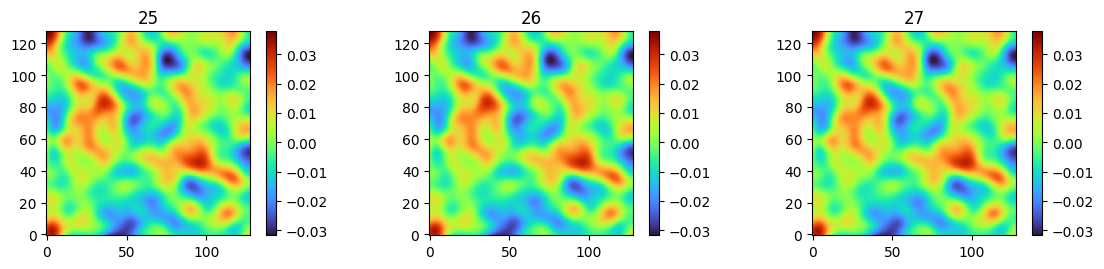

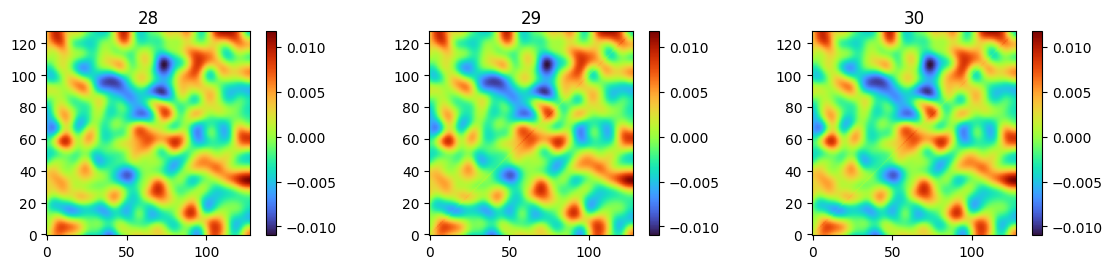

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(331)
plt.imshow(diff2,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("25")
plt.subplot(332)
plt.imshow(diff3,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("26")
plt.subplot(333)
plt.imshow(diff4,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("27")
plt.figure(figsize=(14,9))
plt.subplot(334)
plt.imshow(diff5,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("28")
plt.subplot(335)
plt.imshow(diff6,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("29")
plt.subplot(336)
plt.imshow(diff7,cmap="turbo",origin="lower")
plt.colorbar()
plt.title("30")